In [1]:
#! /usr/bin/env python
# https://github.com/experiencor/keras-yolo3
import argparse
import os
import numpy as np
import json
from voc import parse_voc_annotation
from yolo import create_yolov3_model, dummy_loss
from generator import BatchGenerator
from utils.utils import normalize, evaluate, makedirs
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from callbacks import CustomModelCheckpoint, CustomTensorBoard
from utils.multi_gpu_model import multi_gpu_model
import tensorflow as tf
import keras
from keras.models import load_model

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def create_training_instances(
    train_annot_folder,
    train_image_folder,
    train_cache,
    valid_annot_folder,
    valid_image_folder,
    valid_cache,
    labels,
):
    # parse annotations of the training set
    train_ints, train_labels = parse_voc_annotation(train_annot_folder, train_image_folder, train_cache, labels)
    # parse annotations of the validation set, if any, otherwise split the training set
    if os.path.exists(valid_annot_folder):
        valid_ints, valid_labels = parse_voc_annotation(valid_annot_folder, valid_image_folder, valid_cache, labels)
    else:
        print("valid_annot_folder not exists. Spliting the trainining set.")

        train_valid_split = int(0.8*len(train_ints))
        np.random.seed(0)
        np.random.shuffle(train_ints)
        np.random.seed()

        valid_ints = train_ints[train_valid_split:]
        train_ints = train_ints[:train_valid_split]

    # compare the seen labels with the given labels
    if len(labels) > 0:
        overlap_labels = set(labels).intersection(set(train_labels.keys()))

        print('Seen labels: \t'  + str(train_labels) + '\n')
        print('Given labels: \t' + str(labels))

        # return None, None, None if some given label is not in the dataset
        if len(overlap_labels) < len(labels):
            print('Some labels have no annotations! Please revise the list of labels')
            return None, None, None
    else:
        print('No labels are provided. Train on all seen labels.')
        print(train_labels)
        labels = train_labels.keys()

    max_box_per_image = max([len(inst['object']) for inst in (train_ints + valid_ints)])

    return train_ints, valid_ints, sorted(labels), max_box_per_image

In [3]:
def create_callbacks(saved_weights_name, model_to_save):
    
    early_stop = EarlyStopping(
        monitor     = 'loss', 
        min_delta   = 0.01, 
        patience    = 5, 
        mode        = 'min', 
        verbose     = 1
    )
    checkpoint = CustomModelCheckpoint(
        model_to_save   = model_to_save,
        filepath        = saved_weights_name,# + '{epoch:02d}.h5', 
        monitor         = 'loss', 
        verbose         = 1, 
        save_best_only  = True, 
        mode            = 'min', 
        period          = 1
    )
    reduce_on_plateau = ReduceLROnPlateau(
        monitor  = 'loss',
        patience = 2,
        verbose  = 1,
        mode     = 'min',
        epsilon  = 0.01,
    )    
    return [early_stop, checkpoint, reduce_on_plateau]

In [4]:
def create_model(
    nb_class, 
    anchors, 
    max_box_per_image, 
    max_grid, batch_size, 
    warmup_batches, 
    ignore_thresh,  
    saved_weights_name, 
    lr,
    grid_scales,
    obj_scale=5,
    noobj_scale=1,
    xywh_scale=1,
    class_scale=1  
):
    train_model, infer_model = create_yolov3_model(
        nb_class            = nb_class, 
        anchors             = anchors, 
        max_box_per_image   = max_box_per_image, 
        max_grid            = max_grid, 
        batch_size          = batch_size, 
        warmup_batches      = warmup_batches,
        ignore_thresh       = ignore_thresh,
        grid_scales         = grid_scales,
        obj_scale           = obj_scale,
        noobj_scale         = noobj_scale,
        xywh_scale          = xywh_scale,
        class_scale         = class_scale
    )  

    # load the pretrained weight if exists, otherwise load the backend weight only
    if os.path.exists(saved_weights_name): 
        print("\nLoading pretrained weights.\n")
        train_model.load_weights(saved_weights_name)
    else:
        train_model.load_weights("backend.h5", by_name=True)          

    optimizer = Adam(lr=lr, clipnorm=0.001)
    train_model.compile(loss=dummy_loss, optimizer=optimizer)             

    return train_model, infer_model

In [5]:
# Parse the annotations 
train_annot_folder = './kangaroo/annots/'
train_image_folder = './kangaroo/images/'
cache_name = 'kangaroo_train.pkl'
valid_annot_folder = ''
valid_image_folder = ''
valid_cache_name = ''
labels = ["kangaroo"]

train_ints, valid_ints, labels, max_box_per_image = create_training_instances(
    train_annot_folder,
    train_image_folder,
    cache_name,
    valid_annot_folder,
    valid_image_folder,
    valid_cache_name,
    labels
)
print('\nTraining on: \t' + str(labels) + '\n')

# Create the generators 
anchors = [55,69, 75,234, 133,240, 136,129, 142,363, 203,290, 228,184, 285,359, 341,260]
batch_size = 4
max_input_size = 448
min_input_size = 288

train_generator = BatchGenerator(
    instances           = train_ints, 
    anchors             = anchors,   
    labels              = labels,        
    downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
    max_box_per_image   = max_box_per_image,
    batch_size          = batch_size,
    min_net_size        = min_input_size,
    max_net_size        = max_input_size,   
    shuffle             = True, 
    jitter              = 0.3, 
    norm                = normalize
)

valid_generator = BatchGenerator(
    instances           = valid_ints, 
    anchors             = anchors,   
    labels              = labels,        
    downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
    max_box_per_image   = max_box_per_image,
    batch_size          = batch_size,
    min_net_size        = min_input_size,
    max_net_size        = max_input_size,   
    shuffle             = True, 
    jitter              = 0.0, 
    norm                = normalize
)

# Create the model 
saved_weights_name = 'kangaroo.h5'
warmup_epochs = 3
train_times = 8
ignore_thresh = 0.5
learning_rate = 1e-4
grid_scales = [1,1,1]
obj_scale = 5
if os.path.exists(saved_weights_name): 
    warmup_epochs = 0
warmup_batches = warmup_epochs * (train_times*len(train_generator))

train_model, infer_model = create_model(
    nb_class            = len(labels), 
    anchors             = anchors, 
    max_box_per_image   = max_box_per_image, 
    max_grid            = [max_input_size, max_input_size], 
    batch_size          = batch_size, 
    warmup_batches      = warmup_batches,
    ignore_thresh       = 0.5,
    saved_weights_name  = saved_weights_name,
    lr                  = 1e-4,
    grid_scales         = [1,1,1],

)

# Start training
callbacks = create_callbacks(saved_weights_name, infer_model)
nb_epochs = 100
print('start training')
train_model.fit_generator(
    generator        = train_generator, 
    steps_per_epoch  = len(train_generator) * train_times, 
    epochs           = nb_epochs + warmup_epochs, 
    verbose          = 1,
    callbacks        = callbacks, 
    workers          = 1,
    max_queue_size   = 8
)

valid_annot_folder not exists. Spliting the trainining set.
Seen labels: 	{'kangaroo': 266}

Given labels: 	['kangaroo']

Training on: 	['kangaroo']



/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


start training
Epoch 1/103
264/264 [==============================] - 93s 352ms/step - loss: 192.0681 - yolo_layer_1_loss: 22.8295 - yolo_layer_2_loss: 53.7695 - yolo_layer_3_loss: 115.4691

Epoch 00001: loss improved from inf to 192.06806, saving model to kangaroo.h5
Epoch 2/103
264/264 [==============================] - 58s 221ms/step - loss: 36.3632 - yolo_layer_1_loss: 6.6415 - yolo_layer_2_loss: 10.6960 - yolo_layer_3_loss: 19.0258

Epoch 00002: loss improved from 192.06806 to 36.36322, saving model to kangaroo.h5
Epoch 3/103
264/264 [==============================] - 62s 233ms/step - loss: 29.6077 - yolo_layer_1_loss: 6.0447 - yolo_layer_2_loss: 9.0969 - yolo_layer_3_loss: 14.4661

Epoch 00003: loss improved from 36.36322 to 29.60771, saving model to kangaroo.h5
Epoch 4/103
264/264 [==============================] - 60s 226ms/step - loss: 16.3201 - yolo_layer_1_loss: 3.2086 - yolo_layer_2_loss: 4.8493 - yolo_layer_3_loss: 8.2622

Epoch 00004: loss improved from 29.60771 to 16.320

KeyboardInterrupt: 

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


k.png


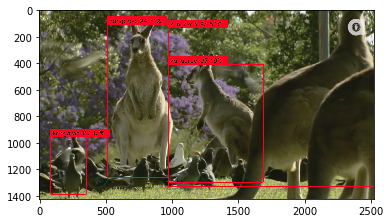

In [6]:
# predict
import os
import argparse
import json
import cv2
from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
from keras.models import load_model
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

input_path   = 'k.png'
# input_path   = 'kangaroo_raw.mp4'

output_path  = 'output/'
makedirs(output_path)

# Set some parameter
net_h, net_w = 416, 416 # a multiple of 32, the smaller the faster
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [55,69, 75,234, 133,240, 136,129, 142,363, 203,290, 228,184, 285,359, 341,260]
labels = ["kangaroo"]

# Load the model
infer_model = load_model('kangaroo_trained.h5')

# Predict bounding boxes 
if input_path[-4:] == '.mp4': # do detection on a video  
    video_out = output_path + input_path.split('/')[-1]
    video_reader = cv2.VideoCapture(input_path)

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

    video_writer = cv2.VideoWriter(video_out,
                           cv2.VideoWriter_fourcc(*'MPEG'), 
                           24.0, 
                           (frame_w, frame_h))
    # the main loop
    batch_size  = 1
    images      = []
    start_point = 0 #%
    show_window = False
    for i in tqdm(range(nb_frames)):
        _, image = video_reader.read()
        if image is None:
            continue
        if (float(i+1)/nb_frames) > start_point/100.:
            images += [image]

            if (i%batch_size == 0) or (i == (nb_frames-1) and len(images) > 0):
                # predict the bounding boxes
                batch_boxes = get_yolo_boxes(infer_model, images, net_h, net_w, anchors, obj_thresh, nms_thresh)

                for i in range(len(images)):
                    # draw bounding boxes on the image using labels
                    draw_boxes(images[i], batch_boxes[i], labels, obj_thresh)   

                    # show the video with detection bounding boxes          
                    if show_window: cv2.imshow('video with bboxes', images[i])  

                    # write result to the output video
                    video_writer.write(images[i]) 
                images = []
            if show_window and cv2.waitKey(1) == 27: break  # esc to quit

    if show_window: cv2.destroyAllWindows()
    video_reader.release()
    video_writer.release()       
else: # do detection on an image or a set of images
    image_paths = []

    if os.path.isdir(input_path): 
        for inp_file in os.listdir(input_path):
            image_paths += [input_path + inp_file]
    else:
        image_paths += [input_path]

    image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'JPEG'])]

    # the main loop
    for image_path in image_paths:
        image = cv2.imread(image_path)
        print(image_path)

        # predict the bounding boxes
        boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, anchors, obj_thresh, nms_thresh)[0]

        # draw bounding boxes on the image using labels
        draw_boxes(image, boxes, labels, obj_thresh) 

        # write the image with bounding boxes to file
        output_img_path = output_path + image_path.split('/')[-1]
        cv2.imwrite(output_img_path, np.uint8(image))
        img = cv2.imread(output_img_path)[:,:,::-1]
        plt.imshow(img)


In [ ]:
!jup